# Using the Xgeo cxhartserver from Python

Full reference can be found on: http://nve-wiki.nve.no/index.php/Web_Chart_Service

In [331]:
# Required imports
import requests
from urllib.parse import urljoin, urlparse
import json
import re
import time
import pandas as pd

In [332]:
%matplotlib inline

## Retrieving data as json

GetChart 


Parameter 

Påkrevd/Valgfri 

Standardverdi 

Kommentar 

ver=<versjonsnummer>  P  1.0  Versjon.  
req=getchart  P  getchart  Tjeneste.  
lang=<language>  V  no  Språk (no, en).  
efmt=<feilformat>  V  image  Angir formatet på eventuelle feilmeldinger.  
chs=<bredde>x<høyde>  V  600x400  Bildestørrelse.  
dpi=<dots per inch>  V  96  Dots per inch.  
chf=<format>  V  image/png  Bildeformat.  
chtt=<title>  V  tom streng  Tittel.  
rt=<tidsoppløsning>  V  0  Tidsoppløsning.  
mth=<metode>  V  inst  Metode.  
time=<fra/til tid>  V  -21;+0  Periodeangivelse.  
timeo=<tidsforskyvning>  V  0  Tidsforskyvning på starttidspunktet.  
cht=<plottetype>  V  lc  Plottetype.  
cdt=<uri>  V  DefaultContentData.xml  Innholdsbeskrivelse.  
sdt=<uri>  V  DefaultStyleDescription.xml  Presentasjonsbeskrivelse.  
chd=<tidsseriedata>  V (hvis cdt) ellers P  ikke relevant  Tidsseriedata.  
ymax=<tall>  V  automatisk i grafkontroll  Maks verdi for Y-akser.  
ymin=<tall>  V  automatisk i grafkontroll  Minimum verdi for Y-akser.  
ydec=<tall>  V  automatisk i grafkontroll  Antall desimaler i Y-akse verdier.  


In [333]:
url = "http://h-web01.nve.no/chartserver/ShowData.aspx?req=getchart&ver=1.0&vfmt=json&time=20130504T0000;20130506T0000&chs=10x10&lang=no&chlf=none&chsl=0;+0&chd=ds=htsre,da=29,id=25100.0,rt=1,cht=col,mth=sum,timeo=6:0|ds=htsry,id=metx[25100;0].6001,mth=sum,rt=1,cht=col&nocache=0.20784913911484182"
print(urlparse(url))

ParseResult(scheme='http', netloc='h-web01.nve.no', path='/chartserver/ShowData.aspx', params='', query='req=getchart&ver=1.0&vfmt=json&time=20130504T0000;20130506T0000&chs=10x10&lang=no&chlf=none&chsl=0;+0&chd=ds=htsre,da=29,id=25100.0,rt=1,cht=col,mth=sum,timeo=6:0|ds=htsry,id=metx[25100;0].6001,mth=sum,rt=1,cht=col&nocache=0.20784913911484182', fragment='')


In [334]:
def chartserver_query(base, mth, ver, fmt, tm, lang, data_req):
    return '{0}?{1}&{2}&{3}&{4}&{5}&{6}'.format(base, mth, ver, fmt, tm, lang, data_req)
    
url_base = 'http://h-web01.nve.no/chartserver/ShowData.aspx'
cs_mth = 'req=getchart'
cs_ver = 'ver=1.0'
cs_fmt = 'vfmt=json'
cs_lang = 'lang=no'
#&chd=ds=htsre,da=29,id=25100.0,rt=1,cht=col,mth=sum,timeo=6:0|
#        ds=htsry,id=metx[25100;0].6001,mth=sum,rt=1,cht=col
#&nocache=0.20784913911484182"

In [335]:
rt = "1:00" # hourly time resolution



| Parameter | Code |
|-----------|------|
|Precipitation|0|
|Wind direction|14|
|Wind speed (10m)|16|
|Air temperature (2m)|17|
|Snow depth| 2002|




In [336]:
def get_hourly(station_id, parameter_id, mth='inst'):
    """
    Allowed methods (mth): inst, mean, min, max, sum
    """
    return "ds=htsre,id={0}.{1},rt=1:00,mth={2}".format(station_id, parameter_id, mth) #,da=29, timeo=6:0

#station_id = 18500 # Bjørnholt
#station_id = 18700 # Blindern
station_id = 54710 # Filefjell
#station_id = 25830 # Finsevatn
# Hourly precipitation
ds_precip = get_hourly(station_id, 0, 'sum')
print(ds_precip)

# Hourly temperature
ds_temp = get_hourly(station_id, 17)

# Hourly wind speed
ds_wind = get_hourly(station_id, 16, 'max')

# Hourly snow depth
ds_snow = get_hourly(station_id, 2002)

ds=htsre,id=54710.0,rt=1:00,mth=sum


In [337]:
def join_data_requests(req_list):
    count = 0
    max = len(req_list)
    req = "chd="
    for r in req_list:
        count += 1
        req += r
        if count<max:
            req +='|'
    return req

data_req = join_data_requests([ds_precip, ds_temp, ds_wind, ds_snow])
print(data_req)

chd=ds=htsre,id=54710.0,rt=1:00,mth=sum|ds=htsre,id=54710.17,rt=1:00,mth=inst|ds=htsre,id=54710.16,rt=1:00,mth=max|ds=htsre,id=54710.2002,rt=1:00,mth=inst


In [338]:
cs_time = 'time=20160127T0000;20160209T0000'

In [339]:
url = chartserver_query(url_base, cs_mth, cs_ver, cs_fmt, cs_time, cs_lang, data_req)
print(url)

http://h-web01.nve.no/chartserver/ShowData.aspx?req=getchart&ver=1.0&vfmt=json&time=20160127T0000;20160209T0000&lang=no&chd=ds=htsre,id=54710.0,rt=1:00,mth=sum|ds=htsre,id=54710.17,rt=1:00,mth=inst|ds=htsre,id=54710.16,rt=1:00,mth=max|ds=htsre,id=54710.2002,rt=1:00,mth=inst


In [340]:
resp = requests.get(url)
data = json.loads(resp.text)

In [341]:
#print(json.dumps(data, indent=2)) # formated printing of a json object

{
    "LegendText": "FILEFJELL - KYRKJEST\u00d8LANE (54710), Sn\u00f8dybde (cm)",
    "Statistics": [],
    "SeriesPoints": [
      {
        "Value": 78,
        "Key": "/Date(1454544000000)/",
        "CorrectionMark": 0
      },
}

In [342]:
def convert_timestr(s, as_string=True):
    """
    :param s: time string returned by chartserver query, e.g. /Date(1457485200000)/
    :return:
    """
    # regular expression to extract the numeric values in the json date string
    regex = re.compile("\d+")
    # extract numerical value, make it a float, and divide by 1000 to get seconds since 1.1.1970
    ds = time.gmtime(float(regex.search(s).group())*0.001)
    if as_string:
        ds = time.strftime("%Y-%m-%dT%H:%M:%S", ds)

    return ds

#df['Key'] = [convert_timestr(s) for s in df['Key']]

#print(df)
# s = re.findall('\(.*?\)', df['Key'][0])
# s = time.gmtime(df['Key'][0])
#print('Done')

In [343]:
# parse data as pandas time-series

ts_list = []
for i in range(len(data)):
    val = [v['Value'] for v in data[i]['SeriesPoints']]
    d = [convert_timestr(v['Key']) for v in data[i]['SeriesPoints']]
    ts_list.append(pd.Series(val, index=d, name=data[i]['LegendText']))

df = pd.concat(ts_list, axis=1)

# print(df)

# make the date the new index
# df.index = df['Key']

# remove the duplicate Key column
# del df['Key']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BA31710>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000C17C160>], dtype=object)

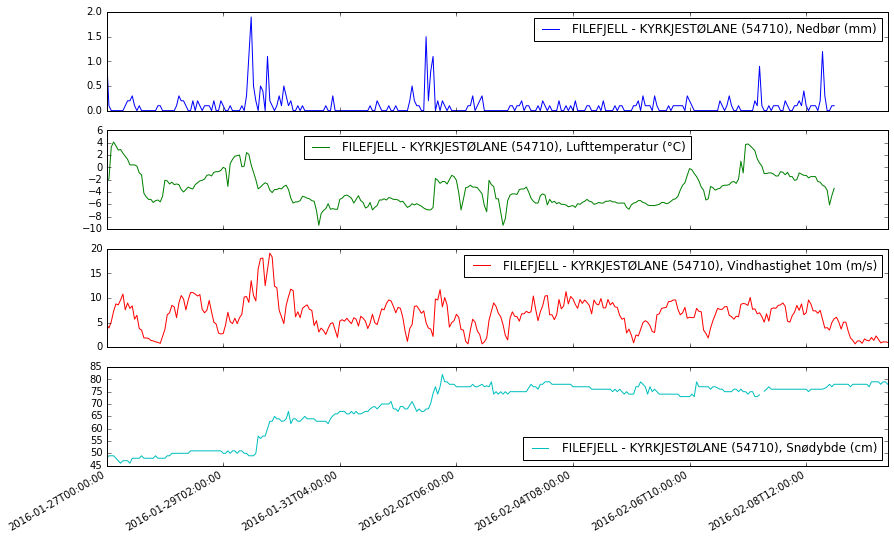

In [344]:
df.plot(subplots='True', figsize=(14, 9))

In [348]:
import sqlite3

In [352]:
db_name = 'filefjell.db'
# Establish connection and cursor
conn = sqlite3.connect(db_name)
#ur = conn.cursor()

df.to_sql(name='FILEFJELL', con=conn)


C:\Anaconda\envs\Anaconda3\lib\site-packages\pandas\core\generic.py:1165: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  chunksize=chunksize, dtype=dtype)


In [353]:
conn.close()